# Calculating Network Error with Loss

## Categorical Cross-Entropy Loss

 Most commonly used loss funtion with the softmax activation on the output layer


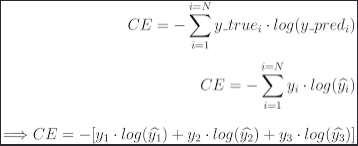


Suppose we have a softmax output :
softmax_output = [0.7, 0.1, 0.2]

and the desired prediction is the first class, then the desired probability distribution is:
[1, 0, 0]

Arrays and vectors like this are calles one-hot and when comparing a models results to one-hot vectors , other parts of the equation zero out making the calculation very simple.

In [65]:
import math

# An example output from and the output layet of the neural network
softmax_output = [0.7, 0.1, 0.2]
# Ground truth
target_output = [1, 0, 0]

loss =  -(math.log(softmax_output[0])*target_output[0] +
         math.log(softmax_output[1])*target_output[1] +
         math.log(softmax_output[2])*target_output[2])

print(loss)



0.35667494393873245


In [66]:
#same as

loss = -(math.log(softmax_output[0]))

print(loss)


0.35667494393873245


Case 1 = [0.22, 0.6, 0.18]
case 2 = [0.32, 0.36, 0.32]

in both cases, the argmax of these vectors will return teh second class as the prediction but the models confidence
level isnt the same.

The Categorical Cross-Entropy Loss accounts for that and outouts a larger loss the lower the confindence is:

In [67]:
import math

print(math.log(1.))
print(math.log(0.95))
print(math.log(0.9))
print(math.log(0.8))
print('...')
print(math.log(0.2))
print(math.log(0.1))
print(math.log(0.05))
print(math.log(0.01))

0.0
-0.05129329438755058
-0.10536051565782628
-0.2231435513142097
...
-1.6094379124341003
-2.3025850929940455
-2.995732273553991
-4.605170185988091


In [68]:
# We need a way to dynamcally calculate cross-entropy

softmax_outputs = [[0.7, 0.1, 0.2],
                   [0.1, 0.5, 0.4],
                   [0.02, 0.9, 0.08]]

class_targets = [0, 1, 1]

for targ_idx, distribution in zip(class_targets, softmax_outputs): #zip() function lets us iterate over multiple iterables at the same time
    print(distribution[targ_idx])

0.7
0.5
0.9


In [69]:
# With NumPy , we create a NumPy array this time
import numpy as np


softmax_outputs = np.array([[0.7, 0.1, 0.2],
                   [0.1, 0.5, 0.4],
                   [0.02, 0.9, 0.08]])

class_targets = [0, 1, 1]

print(softmax_outputs[[0, 1, 2], class_targets])
# Here we index an array in NumPy, but we could also use a range() instead

[0.7 0.5 0.9]


In [70]:
print(softmax_outputs[range(len(softmax_outputs)), class_targets]) #This returns the list of confidences at the target indices for 
# each of the samples

[0.7 0.5 0.9]


In [71]:
# with the negative log
print(-np.log(softmax_outputs[
    range(len(softmax_outputs)), class_targets]) )

[0.35667494 0.69314718 0.10536052]


The next thing we want is the average loss per batch. The most basic way to calculate avg in python is the arithmetic mean: sum(iterable)/len(iterable). However NumPy has a method that computes this average on arrays:

In [72]:
neg_log = -np.log(softmax_outputs[
    range(len(softmax_outputs)), class_targets
])

average_loss = np.mean(neg_log)

print(average_loss)

0.38506088005216804


targets can either be one-hot coded or they can be sparse, which means that the numbers they contain are the correct class numbers. We want the loss funtion to be able to accept any of these forms


In [73]:
import numpy as np

softmax_outputs = np.array([[0.7, 0.1, 0.2],
                            [0.1, 0.5, 0.4],
                            [0.02, 0.9, 0.08]])
class_targets = np.array([[1, 0, 0],
                          [0, 1, 0],
                          [0, 1, 0]])

# Probabilities for target values
# Only if categorical labels

if len(class_targets.shape) == 1:
    correct_confidences = softmax_outputs[range(len(softmax_outputs)), class_targets]
# Mask values - only for one-hot encoded labels
elif len(class_targets.shape) == 2:
    correct_confidences = np.sum(
        softmax_outputs*class_targets, 
        axis=1)
    
# Losses
neg_log = -np.log(correct_confidences)

average_loss = np.mean(neg_log)
print(average_loss)

0.38506088005216804


In [74]:
import numpy as np

print(-np.log(0))

inf


C:\Users\Bilal\AppData\Local\Temp\ipykernel_19248\3370398627.py:3: RuntimeWarning: divide by zero encountered in log
  print(-np.log(0))


In [75]:
print(np.e**(-np.inf))

0.0


In [76]:
import numpy as np

print(np.mean([1, 2, 3, -np.log(0)]))

inf


C:\Users\Bilal\AppData\Local\Temp\ipykernel_19248\3055906385.py:3: RuntimeWarning: divide by zero encountered in log
  print(np.mean([1, 2, 3, -np.log(0)]))


In [77]:
print(-np.log(1e-7))

16.11809565095832


In [78]:
print(-np.log(1+1e-7))

-9.999999505838704e-08


In [79]:
print(-np.log(1-1e-7))

1.0000000494736474e-07


We will use these small ajustments of 1+/- 1e-7 in order to prevenet loss from being exactly 0 and avoid overshifting confidence to 1
 

In [80]:
# method to preform clipping on an array

# i.e The clip() function in numpy serves to ensure that all elements in an array are within a specified range.
# It "clips" any values that fall outside that range to the boundary values.

y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

NameError: name 'y_pred' is not defined

# The Categorical Cross-Entropy Loss Class

Later we will discuss more loss functions but regardless of the funtion, the overall loss is always a mean value of all sample losseS. For now we will creat a Loss Class containing the Calculate method that will call the loss object's forward methd and calculate the mean value of the returned sample losses:

In [81]:
# Common Loss class
class Loss:
    
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        
        # calculate sample losses
        sample_losses = self.forward(output, y)
    
        # calculate mean loss
        data_loss = np.mean(sample_losses) #array of -log values of correct_confidences, either form 1_D or 2_D
        
        # return loss
        return data_loss

Let's convert our loss code into a class for convenience down the line

In [82]:
# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss): #inherit the loss class
    
    #  Forward pass
    def forward(self, y_pred, y_true):
        
        # Number of samples in batch
        samples = len(y_pred)
        
        # clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        # Probabilities for target values
        # only if categorical variables
        if len(y_true.shape) == 1:
            # for each sample (row), it's pulling out the predicted probability of the true class label. y_true is probably a 1_D array containing the true class label in each entry associated with each row
            correct_confidences = y_pred_clipped[range(samples), y_true] 
        
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1) #matrix multiplication to end up with a 1_d NumPy array, 
            # summed across the columns, so for every row you're summing all the multiplies values
            
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences) #take the negative log as per the cross-entropy formula
        return negative_log_likelihoods
    
             

In [83]:
print(len(class_targets.shape))
print(correct_confidences)
print(softmax_outputs)
print(class_targets)
# print(negative_log_likelihoods)

2
[0.7 0.5 0.9]
[[0.7  0.1  0.2 ]
 [0.1  0.5  0.4 ]
 [0.02 0.9  0.08]]
[[1 0 0]
 [0 1 0]
 [0 1 0]]


In [84]:
loss_function = Loss_CategoricalCrossentropy()
loss = loss_function.calculate(softmax_outputs, class_targets)
print(loss)

0.38506088005216804


# Combining Everything up to this Point

In [86]:
from nnfs.datasets import spiral_data
import numpy as np
import nnfs

# The init() function sets the random seed of numpy to a constant, and sets the default data type of numpy to a float type 
# that is more suitable for neural networks and similar works.
nnfs.init()

# Dense layer
class Layer_Dense:
    
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        # notice the size of the matrix is n_inputs X n_neurons and not the other way around, we do this to avoid having to transpose the 
        # weights matrix later. 
        
        self.biases = np.zeros((1, n_neurons))
        # 1 X n_n_neurons  Array
    
    # Forward pass
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases

In [87]:
# ReLU activation
class Activation_ReLU:
    
    # Forward pass
    def forward(self, inputs):
        # calculate output values from input
        self.output = np.maximum(0, inputs)

In [88]:
# Softmax activation
class Activation_Softmax:
    
    # Forward pass
    def forward(self, inputs):
        
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        
        self.output = probabilities

In [89]:
# Common Loss class
class Loss:
    
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        
        # calculate sample losses
        sample_losses = self.forward(output, y)
    
        # calculate mean loss
        data_loss = np.mean(sample_losses) #array of -log values of correct_confidences, either form 1_D or 2_D
        
        # return loss
        return data_loss

In [90]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create dense later with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 3 input features (as we take the output of the previous layer here) and 3 output values
dense2 = Layer_Dense(3, 3)

# Create Softmax activation (to be used with Dense layer)
activation2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossentropy()



# Make a forward pass of our training data through this layer
dense1.forward(X)

# Make forward pass through activation function
# it takes the output of the first dense layer here
activation1.forward(dense1.output) #ReLU activation which considers max(0, input ) and the input is w*X +bias

# Make a forward pass through second Dense layer
# it takes outputs of the activation function which took the first layer's outputs as inputs
dense2.forward(activation1.output)

# Make a forward pass through 2nd activation function
# it takes the outputs of the second dense layer here
activation2.forward(dense2.output) #Softmax activation which exponentiates , substracts with max, then divides each Exp batch by sum of each row


# Let's see output of the first few samples:
print(activation2.output[:5])


# Preforms a forward pass through activation function
# it takes the output of second dense layer here and returns loss
loss = loss_function.calculate(activation2.output, y)

# Print loss value
print(f'loss: {loss}')

[[0.33333334 0.33333334 0.33333334]
 [0.3333332  0.3333332  0.33333364]
 [0.3333329  0.33333293 0.3333342 ]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]]
loss: 1.0986104011535645


# Accuracy Calculation

Loss is a useful metric for optimisation of a model, but it is also used along with accuracy which describes how often the largest confidence is the correct class in terms of a fraction

In [91]:
import numpy as np

# Probabilities of 3 samples
softmax_outputs = np.array([[0.7, 0.2, 0.1],
                            [0.5, 0.1, 0.4],
                            [0.02, 0.9, 0.08]])
# Target (ground-truth) labels for 3 samples
class_targets = np.array([0, 1, 1])

# Calculate values along second axis (axis of index 1)
predictions = np.argmax(softmax_outputs, axis=1)
# If targets are onehot coded - convert them
if len(class_targets.shape) == 2:
    class_targets = np.argmax(class_targets, axis=1)
# True evaluates to 1; False to 0
accuracy = np.mean(predictions == class_targets)

print(f'accuracy = {accuracy}')

accuracy = 0.6666666666666666


In [92]:
# full code + accuracy 

from nnfs.datasets import spiral_data
import numpy as np
import nnfs


# The init() function sets the random seed of numpy to a constant, and sets the default data type of numpy to a float type 
# that is more suitable for neural networks and similar works.
nnfs.init()



# Dense layer
class Layer_Dense:
    
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        # notice the size of the matrix is n_inputs X n_neurons and not the other way around, we do this to avoid having to transpose the 
        # weights matrix later. 
        
        self.biases = np.zeros((1, n_neurons))
        # 1 X n_n_neurons  Array
    
    # Forward pass
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        
        
        
        
        # ReLU activation
class Activation_ReLU:
    
    # Forward pass
    def forward(self, inputs):
        # calculate output values from input
        self.output = np.maximum(0, inputs)
        
        
        
        
        
        # Softmax activation
class Activation_Softmax:
    
    # Forward pass
    def forward(self, inputs):
        
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        
        self.output = probabilities
        
        
        
        
        
        # Common Loss class
class Loss:
    
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        
        # calculate sample losses
        sample_losses = self.forward(output, y)
    
        # calculate mean loss
        data_loss = np.mean(sample_losses) #array of -log values of correct_confidences, either form 1_D or 2_D
        
        # return loss
        return data_loss
    
    
    
    
    # Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create dense later with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 3 input features (as we take the output of the previous layer here) and 3 output values
dense2 = Layer_Dense(3, 3)

# Create Softmax activation (to be used with Dense layer)
activation2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossentropy()



# Make a forward pass of our training data through this layer
dense1.forward(X)

# Make forward pass through activation function
# it takes the output of the first dense layer here
activation1.forward(dense1.output) #ReLU activation which considers max(0, input ) and the input is w*X +bias

# Make a forward pass through second Dense layer
# it takes outputs of the activation function which took the first layer's outputs as inputs
dense2.forward(activation1.output)

# Make a forward pass through 2nd activation function
# it takes the outputs of the second dense layer here
activation2.forward(dense2.output) #Softmax activation which exponentiates , substracts with max, then divides each Exp batch by sum of each row


# Let's see output of the first few samples:
print(activation2.output[:5])


# Preforms a forward pass through activation function
# it takes the output of second dense layer here and returns loss
loss = loss_function.calculate(activation2.output, y)

# Print loss value
print(f'loss: {loss}')
        

[[0.33333334 0.33333334 0.33333334]
 [0.3333332  0.3333332  0.33333364]
 [0.3333329  0.33333293 0.3333342 ]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]]
loss: 1.0986104011535645


In [93]:
predictions = np.argmax(activation2.output, axis=1)
# calculate accuracy of model from output of activation2 and targets
# calculate values along first axis
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)

print('acc:', accuracy)

acc: 0.34
